# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Шаги выполнения проекта:**
1.	Загрузим и подготовим данные.
2.	Обучим и проверим модель для каждого региона:
2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
2.2. Обучим модель и сделаем предсказания на валидационной выборке.
2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
2.5. Проанализируем результаты.
3.	Подготовимся к расчёту прибыли:
3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
3.3. Напишем выводы по этапу подготовки расчёта прибыли.
4.	Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
4.1. Выберем скважины с максимальными значениями предсказаний. 
4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
4.3. Рассчитаем прибыль для полученного объёма сырья.
5.	Посчитаем риски и прибыль для каждого региона:
5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 

•	/datasets/geo_data_0.csv. Скачать датасет

•	/datasets/geo_data_1.csv. Скачать датасет

•	/datasets/geo_data_2.csv. Скачать датасет

•	id — уникальный идентификатор скважины;

•	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

•	product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.
рублей, поскольку объём указан в тысячах баррелей.

•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Загрузка и подготовка данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm_notebook
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [2]:
# Снимем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# Снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# Игнорируем предупреждения
pd.set_option('chained_assignment', None)

In [3]:
# Загрузим данные
try:
    for i in range(3):
        globals()[f'region{i + 1}'] = pd.read_csv(f'/datasets/geo_data_{i}.csv')    
except:
    for i in range(3):
        globals()[f'region{i + 1}'] = pd.read_csv(f'geo_data_{i}.csv')

Данные региона 1 :
Данные датасета:
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Описание датасета:
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.5

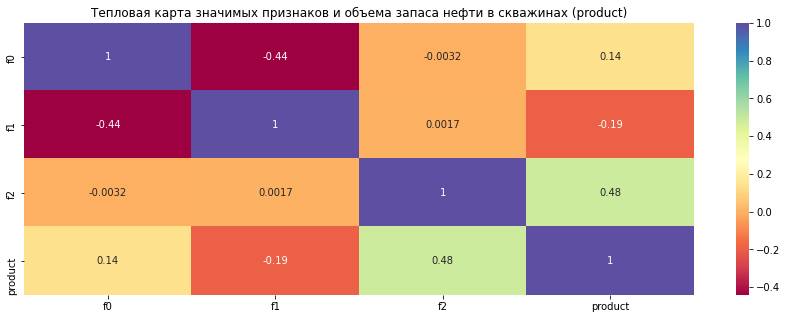

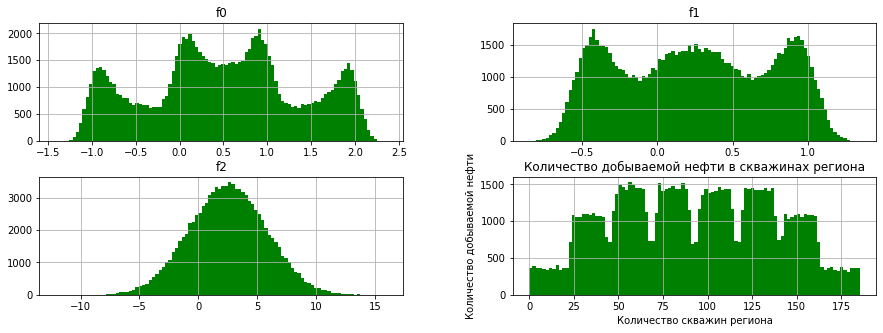

**************************************************************************
Данные региона 2 :
Данные датасета:
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

Информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Описание датасета:
                  f0             f1             f2        product
count  100000.000000  10

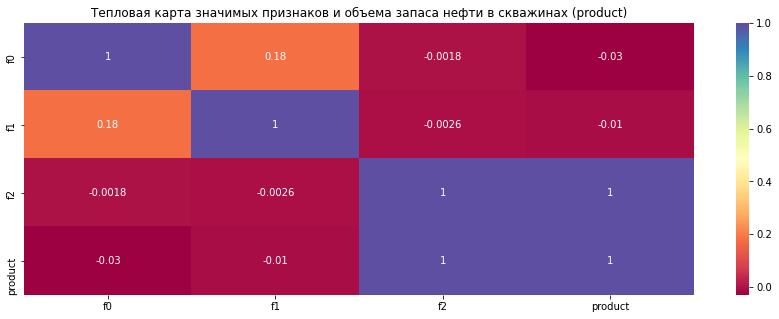

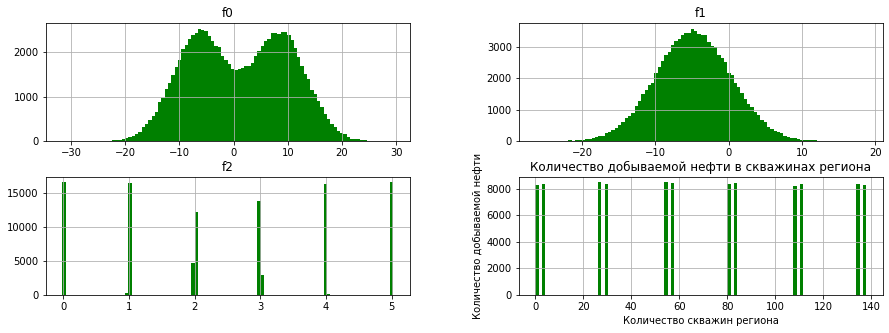

**************************************************************************
Данные региона 3 :
Данные датасета:
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

Информация датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Описание датасета:
                  f0             f1             f2        product
count  100000.000000  100000.000000 

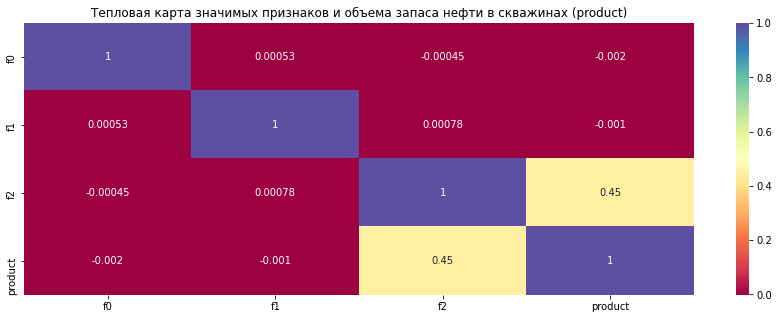

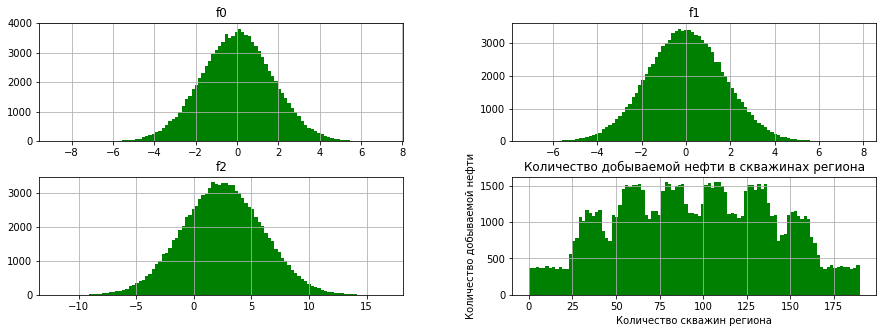

**************************************************************************


In [5]:
# Посмотрим загруженные данные
reg = 1
for data in [region1, region2, region3]:
    print('Данные региона', reg, ':')
    print('Данные датасета:')
    print(data.head())
    print()
    print('Информация датасета:')
    print(data.info())
    print()
    print('Описание датасета:')
    print(data.describe())
    print()
    print(f'Количествово пропусков:{data.isna().sum()}') 
    print()
    print(f'Количествово дубликатов:{data.duplicated().sum()}')
    print()
    print('Уникальные значения датасета:')
    print(data.nunique())
    print()
    corr_matrix = data.corr()
    print(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="Spectral")
    ax.set(title='Тепловая карта значимых признаков и объема запаса нефти в скважинах (product)')
    
    data.hist(figsize=(15, 5), bins=100, color='green')
    plt.title('Количество добываемой нефти в скважинах региона')
    plt.xlabel('Количество скважин региона')
    plt.ylabel('Количество добываемой нефти')
    plt.show()
    print('**************************************************************************')
    reg += 1;

Явных дубликатов нет, но проверим, есть ли наличие неявных.

In [6]:
print(region1['id'].value_counts().head())
print(region2['id'].value_counts().head())
print(region3['id'].value_counts().head())

AGS9W    2
bxg6G    2
TtcGQ    2
bsk9y    2
A5aEY    2
Name: id, dtype: int64
wt4Uk    2
bfPNe    2
LHZR0    2
5ltQ6    2
gnhKA    1
Name: id, dtype: int64
KUPhW    2
Vcm5J    2
xCHr8    2
VF7Jo    2
0EC0g    1
Name: id, dtype: int64


In [7]:
# Посмотрим рандомные данные
print(region1.query('id == "QcMuo"'))
print()
print(region2.query('id == "wt4Uk"'))
print()
print(region3.query('id == "KUPhW"'))

          id        f0        f1        f2    product
1949   QcMuo  0.506563 -0.323775 -2.215583  75.496502
63593  QcMuo  0.635635 -0.473422  0.862670  64.578675

          id         f0        f1        f2     product
47591  wt4Uk  -9.091098 -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305

          id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802


В датасетах есть сведения о скважинах с одинаковыми именами, но разными признаками. Возможно это ошибка заполнения данных. Таких дублирующихся скважин немного, поэтому удалим их, оставив только уникальные. На качество модели удаление такого небольшого количества данных повлиять не должно.

In [8]:
# Отобразим размер датасетов до удаления
print(region1.shape)
print(region2.shape)
print(region3.shape)

(100000, 5)
(100000, 5)
(100000, 5)


In [9]:
# Напишем функцию для удаления наблюдений с дублирующимися id
def remove_double (data):
    names = data['id'].value_counts().reset_index()
    unique_names = names.query('id == 1')['index'].to_list()
    data.query('id in @unique_names', inplace=True)

In [10]:
# Применим функцию ко всем трем датасетам и проверим, как что они изменились
remove_double(region1)
print(region1.shape)
remove_double(region2)
print(region2.shape)
remove_double(region3)
print(region3.shape)

(99980, 5)
(99992, 5)
(99992, 5)


In [11]:
# Удалим из каждого датафрейма столбец id, так как он для нас бесполезен
region1 = region1.drop(['id'], axis=1)
region2 = region2.drop(['id'], axis=1)
region3 = region3.drop(['id'], axis=1)

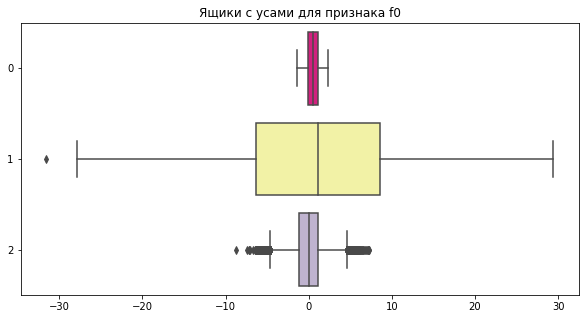

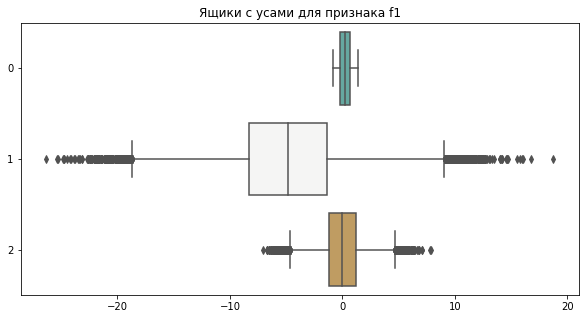

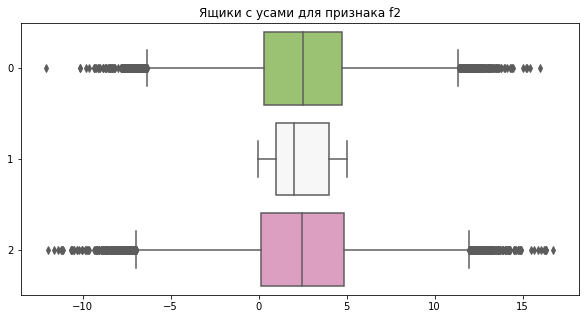

In [12]:
# Посмотрим на выбросы в признаках
plt.figure(figsize=(10,5))
sns.boxplot(data=[region1.f0, region2.f0, region3.f0], palette='Accent_r', orient='h')
plt.title('Ящики с усами для признака f0')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=[region1.f1, region2.f1, region3.f1], palette='BrBG_r', orient='h')
plt.title('Ящики с усами для признака f1')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=[region1.f2, region2.f2, region3.f2], palette='PiYG_r', orient='h')
plt.title('Ящики с усами для признака f2')
plt.show()

Есть выбросы/явные "хвосты":

- в столбце f2 датафреймов region1 и region3
- в столбце f1 датафреймов region2 и region3
- в столбце f0 датафрейма region3

**Итог:**  

Импортировали все необходимые инструменты, загрузили датасеты и ознакомились с ними. Видим, что:

- В трех датасетах отсутствуют явные дубликаты, а неявные в id мы удалили, как и сам столбец id после этого
- Гистограммы демонстрируют, что распределения переменных существенно различаются для каждого региона. В частности, некоторые аномалии в данных, такие как в столбцах `f2` и `product` во втором датасете могут препятствовать обучению.
- Показатели корреляции регионов 1 и 3 похожи, сильной корреляции данных (мультиколлинеарности) нет, больше всего зависит целевой признак product от признака f2. А в регионе 2 заметна неправдоподобная взаимосвязь этих двух признаков - единица. Это может быть связано с тем, что данные синтетические, в реальной жизни такой коэффициент корреляции сложно представить. Либо это человеческая/техническая ошибка заполнения/обработки/передачи данных.
- Не ясно, что такое f0, f1, f2. А выбросов в них очень много. Это могут быть человеческие или технические ошибки при заполнении данных. Сложно сказать какое влияние может оказать удаление этих данных, поэтому их не трогаем.

## Обучение и проверка модели

Как и требовалось в условии задачи, будем обучать модель с помощью линейной регрессии. Напишем функцию, которая разобьет данные на обучающую и валидационную выборки в соотношении 75:25, а затем обучит модель и сделает предсказания на валидационной выборке.

In [13]:
targets = []
predictions = []

def train_test_model_func(): 
    reg = 1
    
    for data in [region1, region2, region3]:
        predictions_valid = 0
        target_valid = 0

        # Создаём датасеты с признаками для трех регионов значения целового признака
        features = data.drop(['product'], axis=1)
        # Создаём датасеты с целевым призаком 
        target = data['product']

        # Разобьём на тренировочную (0.75) и валидационную (0.25) выборку 
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, test_size=0.25, random_state=12345) 
        
        targets.append(target_valid)
        
        # Масштабирование признаки перед обучением модели
        scaler = StandardScaler()

        scaler.fit(features_train)
        features_train = scaler.transform(features_train)
        features_valid = scaler.transform(features_valid)

        # Обучим модель линейной регрессии
        model = LinearRegression() 
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid)

        predictions.append(predictions_valid)
        
        # Найдём RMSE
        rmse = mean_squared_error(target_valid, predictions_valid)**0.5

        print('Данные региона', reg, ':')
        print('RMSE на валидационной выборке =', round(rmse, 3))
        print('Средний предсказанный запас сырья =', round(target_valid.mean(), 3), 'тысяч баррелей')
        print('Средний реальный запас сырья = ', round(target.mean(),3), 'тысяч баррелей')
        print('Разница между реальным и предсказанным запасами сырья =', 
              round(target.mean() - target_valid.mean(), 3), 'тысяч баррелей')
        print('***********************************************************************************************')
        reg += 1

    return predictions, targets

In [14]:
train_test_model_func()

Данные региона 1 :
RMSE на валидационной выборке = 37.717
Средний предсказанный запас сырья = 92.393 тысяч баррелей
Средний реальный запас сырья =  92.499 тысяч баррелей
Разница между реальным и предсказанным запасами сырья = 0.106 тысяч баррелей
***********************************************************************************************
Данные региона 2 :
RMSE на валидационной выборке = 0.891
Средний предсказанный запас сырья = 68.98 тысяч баррелей
Средний реальный запас сырья =  68.824 тысяч баррелей
Разница между реальным и предсказанным запасами сырья = -0.156 тысяч баррелей
***********************************************************************************************
Данные региона 3 :
RMSE на валидационной выборке = 39.976
Средний предсказанный запас сырья = 94.548 тысяч баррелей
Средний реальный запас сырья =  94.999 тысяч баррелей
Разница между реальным и предсказанным запасами сырья = 0.451 тысяч баррелей
********************************************************************

([array([ 62.28661337,  70.42817752,  87.34956247, ...,  95.05743312,
          78.94454642, 115.48299868]),
  array([ 55.97173467,  54.63363312,  54.67483347, ..., 110.00204638,
         137.90166257,   0.51133538]),
  array([ 42.98902811,  95.46229171, 109.40809048, ...,  85.50757813,
         111.31955742,  75.94431003])],
 [6169      61.171722
  29916     94.192535
  49569    137.742601
  47001     10.936404
  5723      49.611033
              ...    
  78253     12.229729
  1870     123.241718
  24146     59.061651
  2502      53.837329
  92485    114.154577
  Name: product, Length: 24995, dtype: float64,
  20914     57.085625
  65272     57.085625
  16622     53.906522
  66091    134.766305
  72146     84.038886
              ...    
  25268      0.000000
  7869     110.992147
  62036    110.992147
  45142    137.945408
  35823      0.000000
  Name: product, Length: 24998, dtype: float64,
  20912     37.147754
  65274     55.498481
  16620     60.024016
  66093     33.638710
  72

**Итог:**

- разбили данные на обучающую и валидационную выборки
- обучили модели и сделали предсказания, сохранили их и правильные ответы
- посчитали средний запас сырья для каждого региона по предсказаниям и RMSE
- качественнее всего модель отработала для региона №2, здесь метрика RMSE с самым маленьким значением. Это значит, что лучше всего модель работает в этом регионе. Это произошло за счет почти прямой корреляции признака f2 с целевым. В остальных регионах RMSE гораздо выше - видимо, есть шумы, и модель не может учесть какие-то важные параметры, лежащие в основе данных. Обычно чем ниже значение mse/rmse, тем более лучший прогноз был получен. Более высокое значение mse/rmse свидетельствует о более выраженном разбросе данных
- средний предсказанный запас сырья больше всего у регионов 1 и 3, больше 90 тысяч бареллей. RMSE же получилось почти 40%

## Подготовка к расчёту прибыли

Наиболее часто для анализа финансовой результативности деятельности организации/проекта используются: оборот (выручка), себестоимость, валовая прибыль, валовая маржинальность, операционная прибыль, операционная маржинальность, чистая прибыль, ROI (возврат на инвестиции).

Исходные данные есть только по одному (первому) показателю: точкой безубыточности для региона является оборот (выручка) в размере 10 млрд. рублей. С учетом стоимости единицы продукта в 450 тыс. руб. рассчитаем, какое количество единиц продукта должно быть добыто для достижения безубыточности региона.

С учетом этой информации объявим ключевые переменные для расчетов:

In [15]:
# Бюджет на разработку нефтяных скважин в отдельно взятом регионе, руб.
BUDGET = 10_000_000_000

# Стоимость одной единицы продукта (тысячи баррелей), руб.
PRODUCT_COST = 450_000

# Стоимость одного барреля, руб.
BARREL_COST = 450

# Соличество скважин для разведки при применении Bootstrap
WELLS_EXPLORATION = 500

# Количество лучших скважин в отдельно взятом регионе
WELLS_BEST = 200

# Количество итераций при применении Bootstrap
ITERATIONS = 1000

Достаточный объём сырья для безубыточной разработки =       111.11 тыс. баррелей

Средний запас в регионе 1 =           92.50 тыс. баррелей
Процент скважин с объёмом больше чем порог =           36.58%
Количество скважин в объёмом больше чем порог =           36576


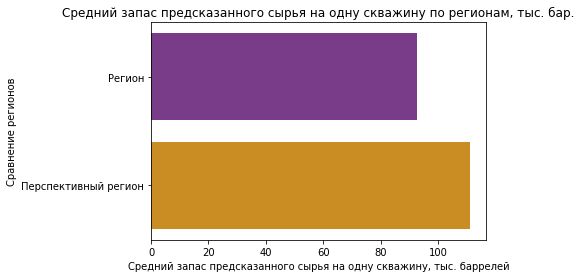

***********************************************************************************************

Средний запас в регионе 2 =           68.82 тыс. баррелей
Процент скважин с объёмом больше чем порог =           16.54%
Количество скважин в объёмом больше чем порог =           16536


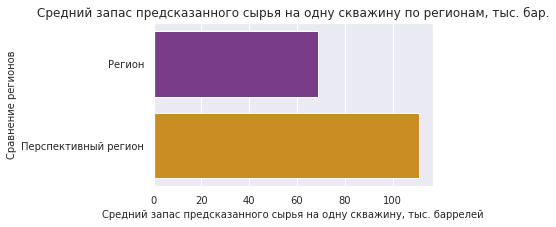

***********************************************************************************************

Средний запас в регионе 3 =           95.00 тыс. баррелей
Процент скважин с объёмом больше чем порог =           38.18%
Количество скважин в объёмом больше чем порог =           38173


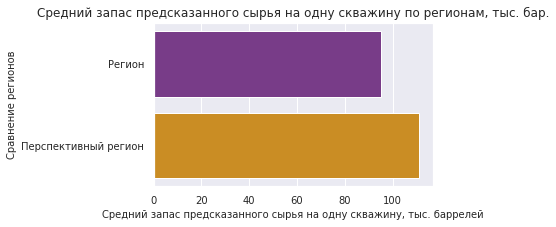

***********************************************************************************************


In [16]:
regions = ['region1', 'region2', 'region3']
data = [region1, region2, region3]

break_even = BUDGET / (PRODUCT_COST * WELLS_BEST)
print(f'Достаточный объём сырья для безубыточной разработки = \
      {break_even:.2f} тыс. баррелей')
reg = 1
for name, data in zip(regions, data):
    print()
    print(f'Средний запас в регионе {reg} = \
          {data["product"].mean():.2f} тыс. баррелей')
    print(f'Процент скважин с объёмом больше чем порог = \
          {len(data.query("product > @break_even")) / len(data):.2%}')
    print(f'Количество скважин в объёмом больше чем порог = \
          {len(data.query("product > @break_even"))}')
    
    # Результаты расчета среднего запаса предсказанонго сырья
    mean_stock = pd.DataFrame(
        {'1': ['Регион', data["product"].mean()],
         '2': ['Перспективный регион', break_even]
        }
    )

    mean_stock = mean_stock.T
    mean_stock.columns = ['Регион', 
                          'Средний запас предсказанного сырья на одну скважину, тыс. баррелей']

    bar_values = mean_stock['Средний запас предсказанного сырья на одну скважину, тыс. баррелей']
    d = sns.barplot(data = mean_stock,
        x = 'Средний запас предсказанного сырья на одну скважину, тыс. баррелей',
        y = 'Регион',
        palette = "CMRmap")
    sns.set(rc={'figure.figsize':(5,3)})
    d.axes.set_title('Средний запас предсказанного сырья на одну скважину по регионам, тыс. бар.')
    d.set_xlabel('Средний запас предсказанного сырья на одну скважину, тыс. баррелей', fontsize=10)
    d.set_ylabel('Сравнение регионов', fontsize=10)
    d.tick_params(labelsize=10)
    plt.show()
    print('***********************************************************************************************')
    reg += 1

**Итоги**

- Обобщены ключевые финансовые условия задания
- Ключевые значения для расчетов сохранены в отдельные переменные
- Рассчитано прогнозируемое общее количество добываемых единиц продукта
- Для обеспечения безубыточности средняя добыча нефти в 200 лучших точках (скважинах) должна составить 111.11 единиц продукта (тыс. баррелей). Средний предскзазанный результат добычи продукта по всем скважинам региона 1 составляет 92.5 тыс. баррелей, региона 2: 68.82 тыс. баррелей, региона 3: 95 тыс. баррелей. Кроме того, из 500 скважин лишь 200 (40%) имеют запасы выше порога.

## Расчёт прибыли и рисков 

Чтобы оценить риски и прибыль используем технику Bootstrap. Создаем 1000 выборок из 500 произвольных скважин с региона по прогнозируемым запасам. Из них берем топ 200, находим их реальные показатели объемов, находим суммарную прибыль для каждой выборки и строим распределение. Посмотрим на 95%-й доверительный интервал и риск убытков.

In [17]:
# Напишем функцию, которая на основе предсказаний, доходов и кол-ва скважин считает прибыль
def profit_func(target, quantity, revenue, count): 
    # Сортируем предсказания по скважинам по убыванию
    wells_sorted = quantity.sort_values(ascending=False) 
    # Отбираем срезом до count индексы скважин с максимальными значениями предсказаний 
    selected = target[wells_sorted.index][:count]

    # DEBUG
    if target[wells_sorted.index].shape[0] != wells_sorted.shape[0]:
        print("Несоответствие формы! Форма выбранных целей:", target[wells_sorted.index].shape)

    return revenue * selected.sum() - BUDGET                  

  0%|          | 0/3 [00:00<?, ?it/s]

Для региона 1 :


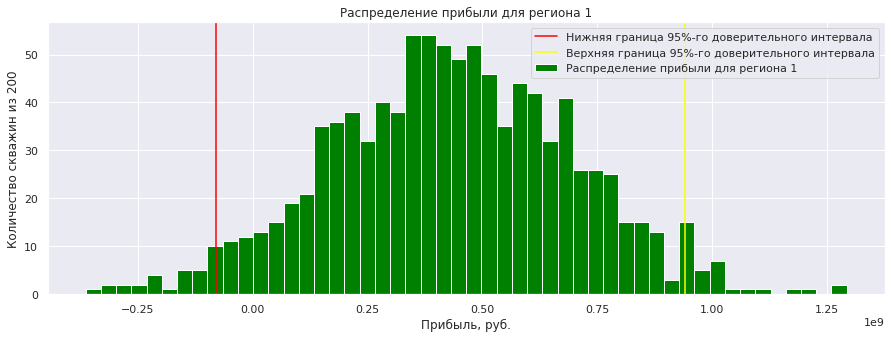

Средняя валовая прибыль с 200 лучших скважин = 431538186.583 млн. рублей.
95% доверительный интервал лежит между [ -80924626.514 : 941037638.4 ] млн. рублей.
Риск убытков = 5.5 %
***********************************************************************************************
Для региона 2 :


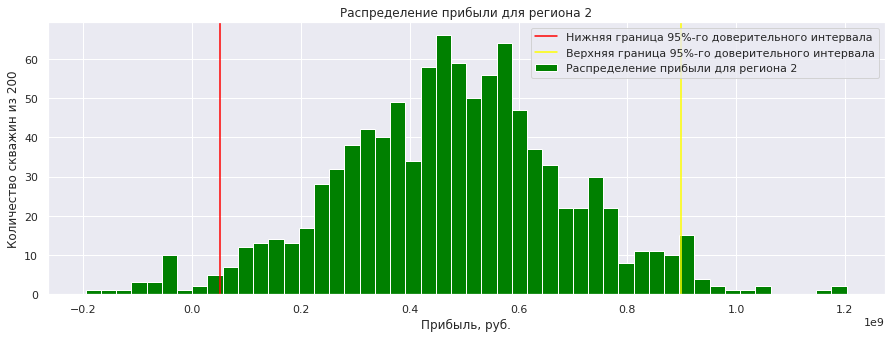

Средняя валовая прибыль с 200 лучших скважин = 477948839.230 млн. рублей.
95% доверительный интервал лежит между [ 51741836.325 : 897944131.398 ] млн. рублей.
Риск убытков = 2.0 %
***********************************************************************************************
Для региона 3 :


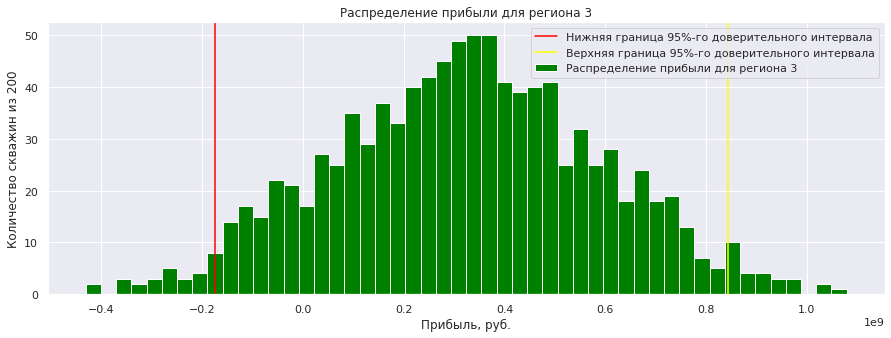

Средняя валовая прибыль с 200 лучших скважин = 322147249.353 млн. рублей.
95% доверительный интервал лежит между [ -173464433.945 : 843529290.071 ] млн. рублей.
Риск убытков = 12.3 %
***********************************************************************************************


In [20]:
reg = 1

for data in tqdm_notebook([region1, region2, region3]):
    
    state = np.random.RandomState(12345)
    
    values = []
    # Переводим массивы предсказаний и целевого признака в pd.Series
    predictions_valid_ = pd.Series(predictions[reg - 1])                                                 
    target_valid_ = pd.Series(targets[reg - 1]).reset_index(drop=True)
    
    for i in range(1000):
        target_subsample = target_valid_.sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions_valid_[target_subsample.index]
        target_subsample = target_subsample.reset_index(drop=True)
        pred_subsample = pred_subsample.reset_index(drop=True)
        values.append(profit_func(target_subsample, pred_subsample, PRODUCT_COST, WELLS_BEST))

    values = pd.Series(values)

    mean_200 = values.mean()
    lower_border = values.quantile(.025)
    upper_border = values.quantile(.975)
    loss_risk = st.percentileofscore(values, 0)
    
    print('Для региона', reg, ':')
    
    # Визуализируем
    values.hist(figsize=(15,5), bins=50, color='green')
    plt.grid(True)
    plt.axvline(values.quantile(0.025), color='red')
    plt.axvline(values.quantile(0.975), color='yellow')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', 
                f'Распределение прибыли для региона {reg}'])
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {reg}')
    plt.show()

    print(f'Средняя валовая прибыль с 200 лучших скважин = {mean_200:.3f} млн. рублей.')
    print('95% доверительный интервал лежит между [', round(lower_border, 3), ':', 
          round(upper_border, 3), '] млн. рублей.')
    print('Риск убытков =', loss_risk, '%')
    print('***********************************************************************************************')
    reg += 1

**Итог**

Проанализировав данные, сравнив риски и доходность с помощью технологии Bootstrap, мы определили, что можно порекомендовать регион 2 для разработки, так как:

- Вероятность убытков в нем 1.4%, то есть меньше 2.5%
- Средняя выручка наибольшая 535246952.329 млн. рублей
- У регионов 1 и 3 вероятность убытков больше 2.5%, поэтому их нельзя рекомендовать для разработки при текущих условиях. Особенно третий регион, так как у этого региона нибольший процент риска - 11.4%.

## Итоговый вывод

В результате выполнения проекта решена задача и достигнута цель - выбран 2 регион для потенциальной разработки, поскольку вероятность убытков там составила менее 2.5%. Также выручка в этом регионе наибольшая. ML модель в этом регионе с большей вероятностью правильно определяет наилучшие нефтерождения и она очень хорошо отсеивает убыточные.

По поводу ML моделей в других регионах они могут сильно ошибаться с предсказаниеми и мы начнём разрабатывать изначально убыточные нефтерождения. Если будет решено разрабатывать нефтерождения в других регионах (из-за более высоких средних показателей количества нефти), то рекомендуется собрать новые/более качественные данные для обучения ML модели. Иначе вероятность финансовых потерь будет очень высока.

Выполнены следующие этапы:

- Исходные данные загружены, проанализированы и обработаны
- Обучена модель линейной регрессии для каждого региона
- Данные разбиты на тренировочные и валидационные
- Признаки отмасштабированы
- Обучена модель, получены предсказания
- Получен средний запас предсказанного сырья и RMSE всех моделей
- Выполнены предварительные вычисления для расчета прибыли
- Все ключевые значения для расчётов сохранены в отдельных переменных
- Расчитан достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей
- Выполнено сравнение полученного объёма сырья со средним запасом в каждом регионе
- Расчитана прибыль и риски убыточной разработки для каждого региона
- Рассчитана средняя прибыль, 95%-й доверительный интервал и риск убытков
- Предложен регион для разработки скважин

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован